# Step 1: Project Setup and Initial Data Overview

In [1]:
!ls

amazon-ml.ipynb
constants.py
images
sample_code.py
sample_test.csv
sample_test_out.csv
sample_test_out_fail.csv
sanity.py
test.csv
train.csv
utils.py
venv


# Step 2: Installing dependencies
(others are installed through pip)

In [3]:
%pip install matplotlib

  Using cached matplotlib-3.9.2-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp312-cp312-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.53.1-cp312-cp312-win_amd64.whl.metadata (165 kB)
  Using cached kiwisolver-1.4.7-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.1.4-py3-none-any.whl.metadata (5.1 kB)
Using cached matplotlib-3.9.2-cp312-cp312-win_amd64.whl (7.8 MB)
Using cached contourpy-1.3.0-cp312-cp312-win_amd64.whl (218 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.53.1-cp312-cp312-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.7-cp312-cp312-win_amd64.whl (55 kB)
Using cached pyparsing-3.1.4-py3-none-any.whl (104 kB)
Note: you may need to restart the kernel to use updated packages.


# Step 3: Importing Libraries and Setting Up the Environment

In [1]:
import os
import pandas as pd
import numpy as np
import requests
from PIL import Image
import pytesseract
import cv2
import matplotlib.pyplot as plt
from io import BytesIO
from tqdm import tqdm
import re
from concurrent.futures import ProcessPoolExecutor
from functools import partial

# Step 4: Loading and Previewing the datasets

In [2]:
# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Display the first few rows of the training data
train.head()

,image_link,group_id,entity_name,entity_value
0,https://m.media-amazon.com/images/I/61I9XdN6OF...,748919,item_weight,500.0 gram
1,https://m.media-amazon.com/images/I/71gSRbyXmo...,916768,item_volume,1.0 cup
2,https://m.media-amazon.com/images/I/61BZ4zrjZX...,459516,item_weight,0.709 gram
3,https://m.media-amazon.com/images/I/612mrlqiI4...,459516,item_weight,0.709 gram
4,https://m.media-amazon.com/images/I/617Tl40LOX...,731432,item_weight,1400 milligram


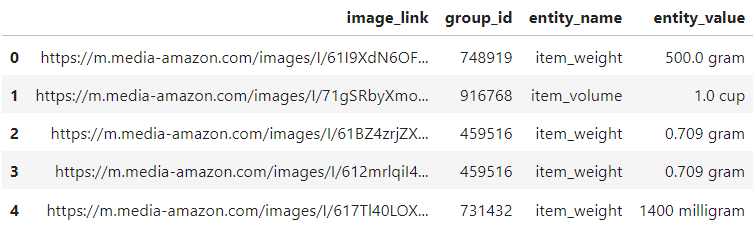

# Step 5: Downloading Images with Multi-threading

In [ ]:
import os
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# Function to download a single image
def download_image(url_idx):
    url, idx, save_folder = url_idx
    image_path = os.path.join(save_folder, f"{idx}.jpg")
    try:
        response = requests.get(url, timeout=5)
        img = Image.open(BytesIO(response.content))
        img.save(image_path)
    except Exception:
        # Skip any issues without printing errors or warnings
        pass

# Function to download images using multi-threading
def download_images_fast_parallel(urls, save_folder, num_threads=10):
    os.makedirs(save_folder, exist_ok=True)
    # Prepare arguments for each image
    url_idx_list = [(url, idx, save_folder) for idx, url in enumerate(urls)]
    
    # Use ThreadPoolExecutor to download images in parallel
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        list(tqdm(executor.map(download_image, url_idx_list), total=len(urls)))

# Set number of threads
num_threads = 50  # Increase the number of threads to 50 for faster downloads

# Download training images quickly using parallel threading
print("Downloading training images quickly with parallel threads...")
download_images_fast_parallel(train['image_link'], 'images/train', num_threads=num_threads)

# Download test images quickly using parallel threading
print("Downloading test images quickly with parallel threads...")
download_images_fast_parallel(test['image_link'], 'images/test', num_threads=num_threads)

100%|████████████████████████████████████████████████████████████████████████| 263859/263859 [1:47:11<00:00, 41.03it/s]


100%|█████████████████████████████████████████████████████████████████████████▉| 130973/131187 [40:25<00:13, 15.68it/s]

# Step 6: Batch-wise Text Extraction from Images using EasyOCR with GPU Support

In [9]:
import easyocr
import os
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import torch
from PIL import Image
import numpy as np

# Initialize EasyOCR reader with GPU support (use GPU if available)
reader = easyocr.Reader(['en'], gpu=True)  # Set GPU=True to use the GPU

# Function to extract text from an image with resizing
def extract_text_from_image(image_path, resize_factor=0.2):  # Reduced resize factor to reduce memory load
    try:
        # Open image using PIL
        img = Image.open(image_path)
        
        # Optionally resize image to reduce memory usage
        if resize_factor < 1.0:
            new_size = (int(img.width * resize_factor), int(img.height * resize_factor))
            img = img.resize(new_size)

        # Convert the PIL image to a numpy array for EasyOCR
        img_np = np.array(img)

        # Use EasyOCR to extract text directly
        result = reader.readtext(img_np, detail=0)  # detail=0 returns only text
        torch.cuda.empty_cache()  # Clear GPU memory after each operation
        
        return ' '.join(result)  # Combine all extracted text
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return ""

# Function to process OCR for a single image
def process_image_for_ocr(idx_image):
    idx, image_path = idx_image
    if os.path.exists(image_path):
        return idx, extract_text_from_image(image_path)
    else:
        print(f"Image not found: {image_path}")
        return idx, ""

# Function to process images in batches
def extract_text_from_images_batch(train, save_folder, batch_size=2000, num_threads=20):  # Use batches and lower threads
    total_images = len(train)
    for i in range(0, total_images, batch_size):
        batch_train = train.iloc[i:i + batch_size]
        idx_image_list = [(idx, os.path.join(save_folder, f"{idx}.jpg")) for idx in batch_train.index]

        with ThreadPoolExecutor(max_workers=num_threads) as executor:
            results = list(tqdm(executor.map(process_image_for_ocr, idx_image_list), total=len(idx_image_list)))

        # Save the extracted text into the main train DataFrame
        for idx, text in results:
            train.at[idx, 'extracted_text'] = text

        # Save progress after every batch
        print(f"Processed batch {i//batch_size + 1}/{total_images//batch_size + 1}")
        train.to_csv(f'train_with_extracted_text_partial_{i//batch_size + 1}.csv', index=False)

# Set the number of threads and batch size for parallel processing
num_threads = 20  # Start with 5 threads to reduce memory usage
batch_size = 2000  # Process 500 images in each batch to avoid memory overflow

# Extract text from training images in batches
print("Extracting text from training images in batches with parallel threads and GPU support...")
extract_text_from_images_batch(train, 'images/train', batch_size=batch_size, num_threads=num_threads)

# Save the final result after all batches are processed
train.to_csv('train_with_extracted_text_final.csv', index=False)

print("Text extraction completed and saved to train_with_extracted_text_final.csv.")

Extracting text from training images in batches with parallel threads and GPU support...


 22%|█████████████████▏                                                             | 434/2000 [02:09<05:05,  5.13it/s]

Image not found: images/train\520.jpg


 43%|█████████████████████████████████▋                                             | 852/2000 [04:16<08:48,  2.17it/s]

Image not found: images/train\1096.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:35<00:00,  3.88it/s]


Processed batch 1/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:04<00:00,  4.13it/s]


Processed batch 2/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:13<00:00,  4.05it/s]


Processed batch 3/132


 81%|██████████████████████████████████████████████████████████████▉               | 1614/2000 [08:16<01:17,  5.00it/s]

Image not found: images/train\7754.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:20<00:00,  3.57it/s]


Processed batch 4/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:08<00:00,  4.10it/s]


Processed batch 5/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:25<00:00,  3.96it/s]


Processed batch 6/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:31<00:00,  3.91it/s]


Processed batch 7/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:19<00:00,  4.00it/s]


Processed batch 8/132


 60%|██████████████████████████████████████████████▊                               | 1200/2000 [05:15<02:13,  5.99it/s]

Image not found: images/train\17319.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:06<00:00,  4.11it/s]


Processed batch 9/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:23<00:00,  3.97it/s]


Processed batch 10/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:58<00:00,  4.18it/s]


Processed batch 11/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:38<00:00,  3.86it/s]


Processed batch 12/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:06<00:00,  4.11it/s]


Processed batch 13/132


 27%|████████████████████▉                                                          | 531/2000 [02:09<04:07,  5.92it/s]

Image not found: images/train\26576.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:11<00:00,  4.07it/s]


Processed batch 14/132


 45%|███████████████████████████████████▋                                           | 902/2000 [04:06<05:54,  3.10it/s]

Image not found: images/train\28993.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:38<00:00,  3.86it/s]


Processed batch 15/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:07<00:00,  4.10it/s]


Processed batch 16/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:50<00:00,  4.25it/s]


Processed batch 17/132


 43%|█████████████████████████████████▉                                             | 859/2000 [03:54<04:48,  3.96it/s]

Image not found: images/train\34979.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:22<00:00,  3.98it/s]


Processed batch 18/132


 52%|████████████████████████████████████████▍                                     | 1037/2000 [04:29<04:11,  3.82it/s]

Image not found: images/train\37141.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:11<00:00,  4.07it/s]


Processed batch 19/132


 43%|█████████████████████████████████▉                                             | 859/2000 [04:13<08:42,  2.18it/s]

Image not found: images/train\39111.jpg


 92%|███████████████████████████████████████████████████████████████████████▊      | 1840/2000 [07:59<00:30,  5.33it/s]

Image not found: images/train\39962.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:20<00:00,  3.99it/s]


Processed batch 20/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:11<00:00,  3.62it/s]


Processed batch 21/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:59<00:00,  3.71it/s]


Processed batch 22/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:20<00:00,  3.57it/s]


Processed batch 23/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [10:26<00:00,  3.19it/s]


Processed batch 24/132


 12%|█████████▋                                                                     | 244/2000 [01:31<13:55,  2.10it/s]

Image not found: images/train\48366.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:12<00:00,  3.62it/s]


Processed batch 25/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:05<00:00,  3.66it/s]


Processed batch 26/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:32<00:00,  3.49it/s]


Processed batch 27/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:50<00:00,  3.38it/s]


Processed batch 28/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:15<00:00,  3.60it/s]


Processed batch 29/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:59<00:00,  3.71it/s]


Processed batch 30/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:49<00:00,  3.78it/s]


Processed batch 31/132


 74%|█████████████████████████████████████████████████████████▋                    | 1479/2000 [07:07<02:41,  3.23it/s]

Image not found: images/train\63572.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:45<00:00,  3.42it/s]


Processed batch 32/132


 63%|█████████████████████████████████████████████████▍                            | 1268/2000 [06:40<01:53,  6.45it/s]

Image not found: images/train\65462.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:29<00:00,  3.51it/s]


Processed batch 33/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:04<00:00,  3.67it/s]


Processed batch 34/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:50<00:00,  3.77it/s]


Processed batch 35/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:53<00:00,  3.75it/s]


Processed batch 36/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:46<00:00,  3.80it/s]


Processed batch 37/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:16<00:00,  3.60it/s]


Processed batch 38/132


 47%|█████████████████████████████████████▍                                         | 947/2000 [04:41<04:33,  3.85it/s]

Image not found: images/train\77111.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:53<00:00,  3.75it/s]


Processed batch 39/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:31<00:00,  3.50it/s]


Processed batch 40/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:59<00:00,  3.71it/s]


Processed batch 41/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:51<00:00,  3.76it/s]


Processed batch 42/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:22<00:00,  3.98it/s]


Processed batch 43/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:47<00:00,  3.79it/s]


Processed batch 44/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:32<00:00,  3.91it/s]


Processed batch 45/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:52<00:00,  3.76it/s]


Processed batch 46/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:41<00:00,  3.83it/s]


Processed batch 47/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:55<00:00,  3.73it/s]


Processed batch 48/132


 30%|███████████████████████▌                                                       | 598/2000 [02:46<06:27,  3.62it/s]

Image not found: images/train\96679.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:46<00:00,  3.80it/s]


Processed batch 49/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:06<00:00,  3.66it/s]


Processed batch 50/132


 86%|███████████████████████████████████████████████████████████████████           | 1721/2000 [07:40<00:54,  5.10it/s]

Image not found: images/train\101790.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:31<00:00,  3.91it/s]


Processed batch 51/132


 84%|█████████████████████████████████████████████████████████████████▎            | 1674/2000 [08:01<01:09,  4.71it/s]

Image not found: images/train\103787.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:59<00:00,  3.71it/s]


Processed batch 52/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:42<00:00,  3.43it/s]


Processed batch 53/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:24<00:00,  3.54it/s]


Processed batch 54/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:11<00:00,  3.63it/s]


Processed batch 55/132


 52%|████████████████████████████████████████▏                                     | 1032/2000 [04:56<01:31, 10.54it/s]

Image not found: images/train\111183.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:01<00:00,  3.70it/s]


Processed batch 56/132


 47%|█████████████████████████████████████                                          | 939/2000 [04:44<03:19,  5.32it/s]

Image not found: images/train\113130.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:26<00:00,  3.53it/s]


Processed batch 57/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:52<00:00,  3.76it/s]


Processed batch 58/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:24<00:00,  3.54it/s]


Processed batch 59/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:41<00:00,  3.83it/s]


Processed batch 60/132


 12%|█████████▌                                                                     | 243/2000 [01:00<04:31,  6.47it/s]

Image not found: images/train\120294.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:19<00:00,  4.01it/s]


Processed batch 61/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:30<00:00,  3.92it/s]


Processed batch 62/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:42<00:00,  3.83it/s]


Processed batch 63/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:23<00:00,  3.98it/s]


Processed batch 64/132


 71%|███████████████████████████████████████████████████████▎                      | 1417/2000 [06:35<02:06,  4.61it/s]

Image not found: images/train\129735.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:32<00:00,  3.90it/s]


Processed batch 65/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:43<00:00,  4.96it/s]


Processed batch 66/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:16<00:00, 10.17it/s]


Processed batch 67/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:18<00:00, 10.08it/s]


Processed batch 68/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:22<00:00,  9.88it/s]


Processed batch 69/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:09<00:00, 10.54it/s]


Processed batch 70/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:13<00:00, 10.35it/s]


Processed batch 71/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:15<00:00, 10.25it/s]


Processed batch 72/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:15<00:00, 10.22it/s]


Processed batch 73/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:24<00:00,  9.78it/s]


Processed batch 74/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:13<00:00, 10.31it/s]


Processed batch 75/132


 59%|██████████████████████████████████████████████                                | 1182/2000 [02:00<01:06, 12.23it/s]

Image not found: images/train\151242.jpg
Image not found: images/train\151243.jpg
Image not found: images/train\151245.jpg
Image not found: images/train\151247.jpg
Image not found: images/train\151248.jpg
Image not found: images/train\151249.jpg
Image not found: images/train\151250.jpg
Image not found: images/train\151251.jpg
Image not found: images/train\151252.jpg
Image not found: images/train\151253.jpg
Image not found: images/train\151254.jpg
Image not found: images/train\151255.jpg
Image not found: images/train\151256.jpg
Image not found: images/train\151257.jpg
Image not found: images/train\151258.jpg
Image not found: images/train\151260.jpg
Image not found: images/train\151261.jpg
Image not found: images/train\151262.jpg
Image not found: images/train\151263.jpg
Image not found: images/train\151264.jpg
Image not found: images/train\151265.jpg
Image not found: images/train\151266.jpg
Image not found: images/train\151267.jpg
Image not found: images/train\151268.jpg
Image not found:

 80%|██████████████████████████████████████████████████████████████▍               | 1602/2000 [02:27<00:26, 15.21it/s]

Image not found: images/train\151747.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:08<00:00, 10.61it/s]


Processed batch 76/132


 42%|█████████████████████████████████                                              | 837/2000 [01:41<04:26,  4.36it/s]

Image not found: images/train\152985.jpg
Image not found: images/train\152986.jpg
Image not found: images/train\152989.jpg
Image not found: images/train\152991.jpg
Image not found: images/train\153004.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:46<00:00,  8.84it/s]


Processed batch 77/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:48<00:00,  8.75it/s]


Processed batch 78/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:45<00:00,  8.89it/s]


Processed batch 79/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:41<00:00,  9.04it/s]


Processed batch 80/132


 81%|███████████████████████████████████████████████████████████████               | 1618/2000 [03:08<00:44,  8.66it/s]

Image not found: images/train\161690.jpg
Image not found: images/train\161691.jpg
Image not found: images/train\161692.jpg
Image not found: images/train\161693.jpg
Image not found: images/train\161694.jpg
Image not found: images/train\161695.jpg
Image not found: images/train\161696.jpg
Image not found: images/train\161697.jpg
Image not found: images/train\161698.jpg
Image not found: images/train\161699.jpg
Image not found: images/train\161701.jpg
Image not found: images/train\161705.jpg
Image not found: images/train\161707.jpg
Image not found: images/train\161708.jpg
Image not found: images/train\161709.jpg
Image not found: images/train\161713.jpg
Image not found: images/train\161714.jpg
Image not found: images/train\161715.jpg
Image not found: images/train\161716.jpg
Image not found: images/train\161717.jpg
Image not found: images/train\161720.jpg
Image not found: images/train\161721.jpg
Image not found: images/train\161723.jpg
Image not found: images/train\161724.jpg
Image not found:

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:21<00:00,  9.92it/s]


Processed batch 81/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:49<00:00,  8.73it/s]


Processed batch 82/132


 36%|████████████████████████████▊                                                  | 730/2000 [01:29<02:37,  8.07it/s]

Image not found: images/train\164860.jpg
Image not found: images/train\164864.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:44<00:00,  8.90it/s]


Processed batch 83/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:26<00:00,  9.67it/s]


Processed batch 84/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:34<00:00,  9.33it/s]


Processed batch 85/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:38<00:00,  9.17it/s]


Processed batch 86/132


 81%|███████████████████████████████████████████████████████████████▎              | 1623/2000 [03:01<00:46,  8.12it/s]

Image not found: images/train\173692.jpg
Image not found: images/train\173693.jpg
Image not found: images/train\173694.jpg
Image not found: images/train\173695.jpg
Image not found: images/train\173696.jpg
Image not found: images/train\173697.jpg
Image not found: images/train\173698.jpg
Image not found: images/train\173699.jpg
Image not found: images/train\173700.jpg
Image not found: images/train\173701.jpg
Image not found: images/train\173702.jpg
Image not found: images/train\173703.jpg
Image not found: images/train\173704.jpg
Image not found: images/train\173705.jpg
Image not found: images/train\173706.jpg
Image not found: images/train\173707.jpg
Image not found: images/train\173708.jpg
Image not found: images/train\173709.jpg
Image not found: images/train\173710.jpg
Image not found: images/train\173711.jpg
Image not found: images/train\173712.jpg
Image not found: images/train\173713.jpg
Image not found: images/train\173714.jpg
Image not found: images/train\173715.jpg
Image not found:

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:04<00:00, 10.86it/s]


Processed batch 87/132
Image not found: images/train\174000.jpgImage not found: images/train\174001.jpg

Image not found: images/train\174002.jpg
Image not found: images/train\174003.jpg
Image not found: images/train\174004.jpg
Image not found: images/train\174005.jpg
Image not found: images/train\174006.jpg
Image not found: images/train\174007.jpg
Image not found: images/train\174008.jpg
Image not found: images/train\174010.jpg
Image not found: images/train\174009.jpg
Image not found: images/train\174011.jpg
Image not found: images/train\174012.jpg
Image not found: images/train\174014.jpg
Image not found: images/train\174013.jpg
Image not found: images/train\174015.jpg
Image not found: images/train\174016.jpg
Image not found: images/train\174017.jpg
Image not found: images/train\174018.jpg
Image not found: images/train\174019.jpg
Image not found: images/train\174020.jpg
Image not found: images/train\174021.jpg
Image not found: images/train\174022.jpg
Image not found: images/train\1740

  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]

Image not found: images/train\174160.jpg
Image not found: images/train\174171.jpg
Image not found: images/train\174173.jpg
Image not found: images/train\174177.jpg
Image not found: images/train\174178.jpg
Image not found: images/train\174174.jpg
Image not found: images/train\174180.jpg
Image not found: images/train\174164.jpg
Image not found: images/train\174183.jpg
Image not found: images/train\174184.jpg
Image not found: images/train\174185.jpg
Image not found: images/train\174186.jpg
Image not found: images/train\174172.jpg
Image not found: images/train\174176.jpg
Image not found: images/train\174168.jpg
Image not found: images/train\174179.jpg
Image not found: images/train\174191.jpg
Image not found: images/train\174192.jpg
Image not found: images/train\174182.jpg
Image not found: images/train\174194.jpg
Image not found: images/train\174195.jpg
Image not found: images/train\174166.jpg
Image not found: images/train\174197.jpg
Image not found: images/train\174198.jpg
Image not found:

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:04<00:00, 10.84it/s]


Processed batch 88/132


 54%|██████████████████████████████████████████▏                                   | 1083/2000 [02:35<02:59,  5.12it/s]

Image not found: images/train\177335.jpg


 64%|█████████████████████████████████████████████████▊                            | 1276/2000 [02:43<01:13,  9.88it/s]

Image not found: images/train\177409.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:59<00:00,  8.34it/s]


Processed batch 89/132


  6%|████▋                                                                          | 118/2000 [00:25<06:45,  4.64it/s]

Image not found: images/train\178277.jpg


 77%|████████████████████████████████████████████████████████████                  | 1540/2000 [02:57<00:50,  9.05it/s]

Image not found: images/train\179645.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:38<00:00,  9.14it/s]


Processed batch 90/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:42<00:00,  8.97it/s]


Processed batch 91/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:48<00:00,  6.94it/s]


Processed batch 92/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:46<00:00,  8.82it/s]


Processed batch 93/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:46<00:00,  8.84it/s]


Processed batch 94/132


 24%|██████████████████▉                                                            | 480/2000 [01:01<03:15,  7.79it/s]

Image not found: images/train\188607.jpg
Image not found: images/train\188609.jpg
Image not found: images/train\188610.jpg
Image not found: images/train\188611.jpg
Image not found: images/train\188612.jpg
Image not found: images/train\188613.jpg
Image not found: images/train\188614.jpg
Image not found: images/train\188615.jpg
Image not found: images/train\188616.jpg
Image not found: images/train\188617.jpg
Image not found: images/train\188618.jpg
Image not found: images/train\188619.jpg
Image not found: images/train\188620.jpg
Image not found: images/train\188621.jpg
Image not found: images/train\188622.jpg
Image not found: images/train\188623.jpg
Image not found: images/train\188624.jpg
Image not found: images/train\188625.jpg
Image not found: images/train\188626.jpg
Image not found: images/train\188627.jpg
Image not found: images/train\188628.jpg
Image not found: images/train\188630.jpg
Image not found: images/train\188631.jpg
Image not found: images/train\188632.jpg
Image not found:

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:06<00:00, 10.74it/s]


Processed batch 95/132


 10%|███████▊                                                                       | 198/2000 [00:30<04:58,  6.04it/s]

Image not found: images/train\190297.jpg


 73%|█████████████████████████████████████████████████████████                     | 1464/2000 [02:59<01:29,  6.00it/s]

Image not found: images/train\191552.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:55<00:00,  8.48it/s]


Processed batch 96/132


 18%|██████████████▏                                                                | 358/2000 [00:53<04:03,  6.73it/s]

Image not found: images/train\192535.jpg


 83%|████████████████████████████████████████████████████████████████▍             | 1653/2000 [03:26<01:24,  4.09it/s]

Image not found: images/train\193837.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:55<00:00,  8.50it/s]


Processed batch 97/132


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1894/2000 [03:42<00:10, 10.41it/s]

Image not found: images/train\195963.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:46<00:00,  8.84it/s]


Processed batch 98/132


 46%|████████████████████████████████████▏                                          | 917/2000 [02:16<02:39,  6.79it/s]

Image not found: images/train\197009.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:32<00:00,  7.34it/s]


Processed batch 99/132


 24%|███████████████████                                                            | 484/2000 [01:22<08:05,  3.12it/s]

Image not found: images/train\198609.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:11<00:00,  7.95it/s]


Processed batch 100/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:57<00:00,  8.43it/s]


Processed batch 101/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:42<00:00,  8.99it/s]


Processed batch 102/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:23<00:00,  9.85it/s]


Processed batch 103/132


 43%|██████████████████████████████████▏                                            | 866/2000 [01:35<02:19,  8.12it/s]

Image not found: images/train\206957.jpg
Image not found: images/train\206961.jpg
Image not found: images/train\206963.jpg
Image not found: images/train\206964.jpg
Image not found: images/train\206965.jpg
Image not found: images/train\206966.jpg
Image not found: images/train\206967.jpg
Image not found: images/train\206968.jpg
Image not found: images/train\206969.jpg
Image not found: images/train\206970.jpg
Image not found: images/train\206971.jpg
Image not found: images/train\206972.jpg
Image not found: images/train\206973.jpg
Image not found: images/train\206974.jpg
Image not found: images/train\206975.jpg
Image not found: images/train\206976.jpg
Image not found: images/train\206977.jpg
Image not found: images/train\206978.jpg
Image not found: images/train\206979.jpg
Image not found: images/train\206980.jpg
Image not found: images/train\206981.jpg
Image not found: images/train\206982.jpg
Image not found: images/train\206983.jpg
Image not found: images/train\206984.jpg
Image not found:

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:09<00:00, 10.58it/s]


Processed batch 104/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:13<00:00, 10.35it/s]


Processed batch 105/132


 40%|███████████████████████████████▌                                               | 800/2000 [01:24<01:37, 12.27it/s]

Image not found: images/train\210884.jpg
Image not found: images/train\210889.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:14<00:00, 10.29it/s]


Processed batch 106/132


 16%|████████████▌                                                                  | 317/2000 [00:38<02:31, 11.08it/s]

Image not found: images/train\212390.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:27<00:00,  9.63it/s]


Processed batch 107/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:19<00:00, 10.00it/s]


Processed batch 108/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:15<00:00, 10.22it/s]


Processed batch 109/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:21<00:00,  9.90it/s]


Processed batch 110/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:16<00:00, 10.19it/s]


Processed batch 111/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:27<00:00,  9.62it/s]


Processed batch 112/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:14<00:00, 10.30it/s]


Processed batch 113/132


  2%|██                                                                              | 50/2000 [00:08<03:41,  8.79it/s]

Image not found: images/train\226122.jpg
Image not found: images/train\226124.jpg
Image not found: images/train\226125.jpg
Image not found: images/train\226126.jpg
Image not found: images/train\226127.jpg
Image not found: images/train\226128.jpg
Image not found: images/train\226129.jpg
Image not found: images/train\226130.jpg
Image not found: images/train\226131.jpg
Image not found: images/train\226132.jpg
Image not found: images/train\226133.jpg
Image not found: images/train\226134.jpg
Image not found: images/train\226135.jpg
Image not found: images/train\226136.jpg
Image not found: images/train\226137.jpg
Image not found: images/train\226138.jpg
Image not found: images/train\226139.jpg
Image not found: images/train\226140.jpg
Image not found: images/train\226141.jpg
Image not found: images/train\226142.jpg
Image not found: images/train\226143.jpg
Image not found: images/train\226144.jpg
Image not found: images/train\226145.jpg
Image not found: images/train\226146.jpg
Image not found:

 34%|██████████████████████████▊                                                    | 680/2000 [00:32<01:14, 17.69it/s]

Image not found: images/train\226728.jpg


 79%|█████████████████████████████████████████████████████████████▍                | 1575/2000 [02:06<00:32, 13.02it/s]

Image not found: images/train\227692.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:37<00:00, 12.71it/s]


Processed batch 114/132


  4%|███                                                                             | 78/2000 [00:08<02:14, 14.27it/s]

Image not found: images/train\228180.jpg
Image not found: images/train\228181.jpg
Image not found: images/train\228182.jpg


 36%|████████████████████████████▏                                                  | 715/2000 [01:09<02:14,  9.58it/s]

Image not found: images/train\228826.jpg


 44%|██████████████████████████████████▌                                            | 875/2000 [01:31<02:22,  7.92it/s]

Image not found: images/train\229090.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:03<00:00, 10.90it/s]


Processed batch 115/132


 88%|████████████████████████████████████████████████████████████████████▋         | 1760/2000 [02:50<00:25,  9.58it/s]

Image not found: images/train\231852.jpg
Image not found: images/train\231854.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:07<00:00, 10.66it/s]


Processed batch 116/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:08<00:00, 10.60it/s]


Processed batch 117/132


  8%|██████▏                                                                        | 156/2000 [00:22<03:36,  8.52it/s]

Image not found: images/train\234261.jpg
Image not found: images/train\234263.jpg


 11%|████████▊                                                                      | 222/2000 [00:30<03:51,  7.67it/s]

Image not found: images/train\234337.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:16<00:00, 10.18it/s]


Processed batch 118/132


 59%|██████████████████████████████████████████████▏                               | 1184/2000 [01:55<01:17, 10.57it/s]

Image not found: images/train\237252.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:06<00:00, 10.72it/s]


Processed batch 119/132


 27%|█████████████████████▍                                                         | 542/2000 [00:56<02:33,  9.49it/s]

Image not found: images/train\238647.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:15<00:00, 10.21it/s]


Processed batch 120/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:02<00:00, 10.96it/s]


Processed batch 121/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:04<00:00, 10.86it/s]


Processed batch 122/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:10<00:00, 10.47it/s]


Processed batch 123/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:08<00:00, 10.59it/s]


Processed batch 124/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:08<00:00, 10.62it/s]


Processed batch 125/132


 40%|███████████████████████████████▎                                               | 792/2000 [01:25<01:58, 10.19it/s]

Image not found: images/train\250913.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:12<00:00, 10.39it/s]


Processed batch 126/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:58<00:00, 11.19it/s]


Processed batch 127/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:06<00:00, 10.71it/s]


Processed batch 128/132


 13%|██████████▍                                                                    | 264/2000 [00:27<02:26, 11.82it/s]

Image not found: images/train\256378.jpg


 36%|████████████████████████████▎                                                  | 717/2000 [01:09<01:23, 15.41it/s]

Image not found: images/train\256761.jpg


 37%|█████████████████████████████▎                                                 | 743/2000 [01:13<01:35, 13.21it/s]

Image not found: images/train\256821.jpg


 67%|████████████████████████████████████████████████████▎                         | 1341/2000 [02:11<01:46,  6.18it/s]

Image not found: images/train\257452.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:00<00:00, 11.05it/s]


Processed batch 129/132


 14%|███████████▏                                                                   | 282/2000 [00:40<03:36,  7.93it/s]

Image not found: images/train\258477.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:16<00:00, 10.18it/s]


Processed batch 130/132


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:08<00:00, 10.59it/s]


Processed batch 131/132


 68%|█████████████████████████████████████████████████████▏                        | 1269/1859 [02:04<00:35, 16.64it/s]

Image not found: images/train\263352.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 1859/1859 [02:52<00:00, 10.78it/s]


Processed batch 132/132
Text extraction completed and saved to train_with_extracted_text_final.csv.


# Step 7: Text Preprocessing and Cleaning

In [5]:
import pandas as pd
import re

# Load your DataFrame (Ensure this is the correct file where 'extracted_text' was created)
train = pd.read_csv('train_with_extracted_text_final.csv')

# Check if the 'extracted_text' column exists
if 'extracted_text' in train.columns:
    print("Column 'extracted_text' found. Proceeding with preprocessing.")
    
    # Function to preprocess the extracted text
    def preprocess_text(text):
        # Check if the text is not NaN or None
        if isinstance(text, str):
            # Convert text to lowercase
            text = text.lower()

            # Remove unwanted characters (keep alphanumeric, periods, percentages, and spaces)
            text = re.sub(r'[^a-z0-9.% ]', ' ', text)

            # Remove extra spaces
            text = re.sub(r'\s+', ' ', text).strip()

            return text
        else:
            # Return an empty string if the text is invalid
            return ''

    # Apply the preprocessing function to the 'extracted_text' column
    train['processed_text'] = train['extracted_text'].apply(preprocess_text)

    # Save the DataFrame after preprocessing for future use
    train.to_csv('train_with_preprocessed_text.csv', index=False)

    print("Text preprocessing completed and saved to train_with_preprocessed_text.csv.")
else:
    print("Error: Column 'extracted_text' not found in the DataFrame.")
    print("Please check the previous steps where text extraction is done.")

Column 'extracted_text' found. Proceeding with preprocessing.
Text preprocessing completed and saved to train_with_preprocessed_text.csv.


# Step 8: Entity Value Splitting into Numeric Value and Unit

In [7]:
import re
import numpy as np
import pandas as pd

# Load the DataFrame (make sure this is the correct file)
train = pd.read_csv('train_with_preprocessed_text.csv')

# Function to split entity_value into value and unit
def split_value_unit(entity_value):
    # Convert entity_value to string and apply regex
    pattern = r'([0-9.]+)\s*([a-zA-Z ]+)'  # Pattern to capture numeric value and unit
    match = re.match(pattern, str(entity_value))  # Convert to string to handle NaN or non-string values

    if match:
        try:
            value = float(match.group(1))  # Extract the numeric value
            unit = match.group(2).strip()  # Extract the unit and remove extra spaces
            return value, unit
        except ValueError:
            return np.nan, np.nan  # In case of any value conversion error
    else:
        return np.nan, np.nan  # If no match is found

# Apply the function to the 'entity_value' column
train[['value', 'unit']] = train['entity_value'].apply(lambda x: pd.Series(split_value_unit(x)))

# Save the updated DataFrame to a CSV file for future use
train.to_csv('train_with_value_unit.csv', index=False)

print("Target variables (value and unit) prepared and saved to train_with_value_unit.csv.")

Target variables (value and unit) prepared and saved to train_with_value_unit.csv.


# Step 9: Load Allowed Units and Build a Unit Dictionary

In [8]:
import pandas as pd
import numpy as np

# Assuming the 'constants.py' contains the entity_unit_map, which is a dictionary mapping entity types to allowed units
# Here's how you can load and process it:

# Load allowed units from constants.py (you must have this file in your working directory)
from constants import entity_unit_map

# Create a flat set of all units
all_units = set()
for units in entity_unit_map.values():
    all_units.update(units)

# Sort units by length in descending order to ensure longer units (e.g., "centimetre") are matched first
all_units = sorted(all_units, key=lambda x: -len(x))

# Print the allowed units to ensure they're loaded and sorted properly
print(f"Allowed units loaded and sorted: {all_units}")

# Save the units list into a file for further use if needed
with open('allowed_units_list.txt', 'w') as f:
    for unit in all_units:
        f.write(f"{unit}\n")

print("Allowed units saved to 'allowed_units_list.txt'.")

Allowed units loaded and sorted: ['imperial gallon', 'fluid ounce', 'cubic inch', 'microlitre', 'millilitre', 'cubic foot', 'millimetre', 'centimetre', 'centilitre', 'millivolt', 'decilitre', 'microgram', 'milligram', 'kilogram', 'kilovolt', 'kilowatt', 'gallon', 'quart', 'ounce', 'metre', 'pound', 'litre', 'pint', 'volt', 'watt', 'inch', 'gram', 'foot', 'yard', 'ton', 'cup']
Allowed units saved to 'allowed_units_list.txt'.


# Step 10: Value and Unit Extraction from Text Based on Entity Name

In [11]:
import re
import numpy as np
from constants import entity_unit_map  # Ensure you have 'constants.py' with the 'entity_unit_map' dictionary

# Function to extract value and unit from the preprocessed text
def extract_value_unit_from_text(text, entity_name):
    # Convert the text to string to handle cases where text might be NaN or a non-string type
    text = str(text)
    
    # Get allowed units for the given entity_name (e.g., weight, height, etc.)
    if entity_name not in entity_unit_map:
        print(f"Warning: '{entity_name}' not found in entity_unit_map.")
        return np.nan, ''
    
    units = entity_unit_map[entity_name]

    # Escape units for regex to safely match them in the text
    units_regex = '|'.join([re.escape(unit) for unit in units])

    # Pattern to match numeric value followed by unit (exclude isolated dots)
    pattern = r'([0-9]+(?:\.[0-9]+)?)\s*(' + units_regex + r')\b'

    # Find all matches of value and unit in the text
    matches = re.findall(pattern, text)

    if matches:
        # Return the first match (value, unit)
        value, unit = matches[0]
        
        try:
            return float(value), unit.strip()  # Ensure the value can be converted to float
        except ValueError:
            return np.nan, ''  # Handle conversion errors gracefully
    else:
        return np.nan, ''  # Return NaN and empty unit if no match is found

# Apply the function to each row in the DataFrame
# Use zip to unpack the returned value and unit into two separate columns
train['predicted_value'], train['predicted_unit'] = zip(*train.apply(lambda row: extract_value_unit_from_text(row['processed_text'], row['entity_name']), axis=1))

# Save the result to a new CSV file for future use
train.to_csv('train_with_predicted_value_unit.csv', index=False)

print("Value and unit extraction completed and saved to train_with_predicted_value_unit.csv.")

Value and unit extraction completed and saved to train_with_predicted_value_unit.csv.


# Step 11: Iterative Extraction of Predicted Values and Units

In [12]:
import numpy as np
from tqdm import tqdm

# Initialize columns for predicted values and units
train['predicted_value'] = np.nan
train['predicted_unit'] = ''

print("Extracting predicted values and units from training text...")

# Loop through the DataFrame and apply the extraction function to each row
for idx, row in tqdm(train.iterrows(), total=train.shape[0]):
    text = row['processed_text']
    entity_name = row['entity_name']
    
    # Extract value and unit using the predefined function
    value, unit = extract_value_unit_from_text(text, entity_name)
    
    # Update the DataFrame with the predicted value and unit
    train.at[idx, 'predicted_value'] = value
    train.at[idx, 'predicted_unit'] = unit

# Save the updated DataFrame with the predictions
train.to_csv('train_with_predictions.csv', index=False)

print("Predicted values and units extraction completed and saved to train_with_predictions.csv.")

Extracting predicted values and units from training text...


100%|███████████████████████████████████████████████████████████████████████| 263859/263859 [00:23<00:00, 11365.30it/s]


Predicted values and units extraction completed and saved to train_with_predictions.csv.


# Step 12: Evaluate the Model on Training Data

In [15]:


# Check how many predictions are correct
correct_predictions = train[
    (train['value'].round(2) == train['predicted_value'].round(2)) &  # Ensure both are rounded to handle floating-point precision issues
    (train['unit'].str.lower() == train['predicted_unit'].str.lower())  # Case-insensitive comparison for units
]

# Calculate the accuracy as the percentage of correct predictions
accuracy = len(correct_predictions) / len(train)

print(f"Training Accuracy: {accuracy * 100:.2f}%")

# Save the correct predictions to a separate file for future reference (optional)
correct_predictions.to_csv('correct_predictions.csv', index=False)

print(f"Correct predictions saved to 'correct_predictions.csv'.")

Training Accuracy: 0.60%
Correct predictions saved to 'correct_predictions.csv'.


# Step 13: Batch Text Extraction from Images using EasyOCR with Parallel Processing and GPU Support

In [20]:
import easyocr
import os
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import torch
from PIL import Image
import numpy as np

# Initialize EasyOCR reader with GPU support (use GPU if available)
reader = easyocr.Reader(['en'], gpu=True)  # Set GPU=True to use the GPU

# Function to extract text from an image with resizing
def extract_text_from_image(image_path, resize_factor=0.2):  # Reduced resize factor to reduce memory load
    try:
        # Open image using PIL
        img = Image.open(image_path)
        
        # Optionally resize image to reduce memory usage
        if resize_factor < 1.0:
            new_size = (int(img.width * resize_factor), int(img.height * resize_factor))
            img = img.resize(new_size)

        # Convert the PIL image to a numpy array for EasyOCR
        img_np = np.array(img)

        # Use EasyOCR to extract text directly
        result = reader.readtext(img_np, detail=0)  # detail=0 returns only text
        torch.cuda.empty_cache()  # Clear GPU memory after each operation
        
        return ' '.join(result)  # Combine all extracted text
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return ""

# Function to process OCR for a single image
def process_image_for_ocr(idx_image):
    idx, image_path = idx_image
    if os.path.exists(image_path):
        return idx, extract_text_from_image(image_path)
    else:
        print(f"Image not found: {image_path}")
        return idx, ""

# Function to process images in batches
def extract_text_from_images_batch(test, save_folder, batch_size=2000, num_threads=20):  # Use batches and lower threads
    total_images = len(test)
    for i in range(0, total_images, batch_size):
        batch_test = test.iloc[i:i + batch_size]
        idx_image_list = [(idx, os.path.join(save_folder, f"{idx}.jpg")) for idx in batch_test.index]

        with ThreadPoolExecutor(max_workers=num_threads) as executor:
            results = list(tqdm(executor.map(process_image_for_ocr, idx_image_list), total=len(idx_image_list)))

        # Save the extracted text into the main test DataFrame
        for idx, text in results:
            test.at[idx, 'extracted_text'] = text

        # Save progress after every batch
        print(f"Processed batch {i//batch_size + 1}/{total_images//batch_size + 1}")
        test.to_csv(f'test_with_extracted_text_partial_{i//batch_size + 1}.csv', index=False)

# Set the number of threads and batch size for parallel processing
num_threads = 20  # Adjust this based on your system’s capability (GPU memory)
batch_size = 2000  # Process 2000 images in each batch to avoid memory overflow

# Extract text from test images in batches
print("Extracting text from test images in batches with parallel threads and GPU support...")
extract_text_from_images_batch(test, 'images/test', batch_size=batch_size, num_threads=num_threads)

# Save the final result after all batches are processed
test.to_csv('test_with_extracted_text_final.csv', index=False)

print("Text extraction completed and saved to test_with_extracted_text_final.csv.")

Extracting text from test images in batches with parallel threads and GPU support...


 80%|██████████████████████████████████████████████████████████████▌               | 1605/2000 [00:44<00:13, 29.05it/s]

Image not found: images/test\1673.jpg


 92%|███████████████████████████████████████████████████████████████████████▌      | 1836/2000 [00:51<00:04, 34.39it/s]

Image not found: images/test\1924.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:56<00:00, 35.62it/s]


Processed batch 1/66


  0%|▏                                                                                | 5/2000 [00:02<22:38,  1.47it/s]

Image not found: images/test\2089.jpg


 46%|████████████████████████████████████                                           | 912/2000 [00:34<00:37, 28.83it/s]

Image not found: images/test\3050.jpg


 50%|███████████████████████████████████████                                       | 1001/2000 [00:36<00:31, 31.23it/s]

Image not found: images/test\3106.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:10<00:00, 28.50it/s]


Processed batch 2/66


 14%|███████████▎                                                                   | 286/2000 [00:11<00:48, 35.21it/s]

Image not found: images/test\4377.jpg


 27%|█████████████████████                                                          | 534/2000 [00:22<01:03, 23.18it/s]

Image not found: images/test\4637.jpg


 85%|██████████████████████████████████████████████████████████████████▍           | 1705/2000 [01:01<00:07, 37.72it/s]

Image not found: images/test\5784.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:08<00:00, 29.33it/s]


Processed batch 3/66


 27%|█████████████████████▏                                                         | 536/2000 [00:17<00:27, 53.15it/s]

Image not found: images/test\6576.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 34.91it/s]


Processed batch 4/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:03<00:00, 31.65it/s]


Processed batch 5/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:04<00:00, 31.04it/s]


Processed batch 6/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:05<00:00, 30.66it/s]


Processed batch 7/66


 22%|█████████████████▌                                                             | 444/2000 [00:14<01:14, 21.01it/s]

Image not found: images/test\14527.jpg
Image not found: images/test\14528.jpg
Image not found: images/test\14529.jpg
Image not found: images/test\14530.jpg
Image not found: images/test\14531.jpg
Image not found: images/test\14532.jpg
Image not found: images/test\14533.jpg
Image not found: images/test\14534.jpg
Image not found: images/test\14535.jpg
Image not found: images/test\14536.jpg
Image not found: images/test\14537.jpg
Image not found: images/test\14538.jpg
Image not found: images/test\14539.jpg
Image not found: images/test\14541.jpg
Image not found: images/test\14542.jpg
Image not found: images/test\14543.jpg
Image not found: images/test\14544.jpg
Image not found: images/test\14545.jpg
Image not found: images/test\14546.jpg
Image not found: images/test\14547.jpg
Image not found: images/test\14548.jpg
Image not found: images/test\14550.jpg
Image not found: images/test\14551.jpg
Image not found: images/test\14552.jpg
Image not found: images/test\14553.jpg
Image not found: images/t

 24%|███████████████████                                                            | 482/2000 [00:15<00:43, 35.02it/s]

Image not found: images/test\14622.jpg
Image not found: images/test\14623.jpg
Image not found: images/test\14624.jpg
Image not found: images/test\14625.jpg
Image not found: images/test\14626.jpg
Image not found: images/test\14627.jpg
Image not found: images/test\14628.jpg
Image not found: images/test\14629.jpg
Image not found: images/test\14630.jpg
Image not found: images/test\14631.jpg
Image not found: images/test\14633.jpg
Image not found: images/test\14634.jpg
Image not found: images/test\14635.jpg
Image not found: images/test\14636.jpg
Image not found: images/test\14637.jpg
Image not found: images/test\14638.jpg
Image not found: images/test\14639.jpg
Image not found: images/test\14640.jpg
Image not found: images/test\14641.jpg
Image not found: images/test\14642.jpg
Image not found: images/test\14643.jpg
Image not found: images/test\14644.jpg
Image not found: images/test\14645.jpg
Image not found: images/test\14646.jpg
Image not found: images/test\14647.jpg
Image not found: images/t

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:41<00:00, 48.29it/s]


Processed batch 8/66


 28%|██████████████████████▍                                                        | 568/2000 [00:20<00:37, 37.99it/s]

Image not found: images/test\16638.jpg
Image not found: images/test\16640.jpg
Image not found: images/test\16642.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:06<00:00, 30.28it/s]


Processed batch 9/66


  5%|███▉                                                                           | 100/2000 [00:03<01:02, 30.59it/s]

Image not found: images/test\18135.jpg


 28%|██████████████████████▍                                                        | 567/2000 [00:20<00:45, 31.44it/s]

Image not found: images/test\18612.jpg


 40%|███████████████████████████████▍                                               | 796/2000 [00:27<00:31, 38.24it/s]

Image not found: images/test\18846.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:41<00:00, 19.61it/s]


Processed batch 10/66


 31%|████████████████████████▏                                                      | 612/2000 [00:45<02:00, 11.50it/s]

Image not found: images/test\20766.jpg


 40%|███████████████████████████████▏                                               | 790/2000 [00:49<01:00, 20.06it/s]

Image not found: images/test\20881.jpg


 58%|█████████████████████████████████████████████                                 | 1157/2000 [01:13<00:40, 20.75it/s]

Image not found: images/test\21210.jpg


 60%|██████████████████████████████████████████████▋                               | 1198/2000 [01:16<00:55, 14.42it/s]

Image not found: images/test\21257.jpg


 62%|███████████████████████████████████████████████▉                              | 1230/2000 [01:19<01:10, 10.97it/s]

Image not found: images/test\21299.jpg
Image not found: images/test\21300.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:03<00:00, 16.16it/s]


Processed batch 11/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:09<00:00, 15.49it/s]


Processed batch 12/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:06<00:00, 15.83it/s]


Processed batch 13/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:00<00:00, 16.54it/s]


Processed batch 14/66


 64%|██████████████████████████████████████████████████▏                           | 1286/2000 [01:25<01:08, 10.45it/s]

Image not found: images/test\29360.jpg
Image not found: images/test\29364.jpg
Image not found: images/test\29365.jpg
Image not found: images/test\29366.jpg
Image not found: images/test\29367.jpg
Image not found: images/test\29368.jpg
Image not found: images/test\29369.jpg
Image not found: images/test\29370.jpg
Image not found: images/test\29371.jpg
Image not found: images/test\29372.jpg
Image not found: images/test\29373.jpg
Image not found: images/test\29374.jpg
Image not found: images/test\29375.jpg
Image not found: images/test\29376.jpg
Image not found: images/test\29377.jpg
Image not found: images/test\29378.jpg
Image not found: images/test\29379.jpg
Image not found: images/test\29380.jpg
Image not found: images/test\29381.jpg
Image not found: images/test\29382.jpg
Image not found: images/test\29384.jpg
Image not found: images/test\29385.jpg
Image not found: images/test\29386.jpg
Image not found: images/test\29387.jpg
Image not found: images/test\29388.jpg
Image not found: images/t

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:43<00:00, 19.28it/s]


Processed batch 15/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:08<00:00, 15.57it/s]


Processed batch 16/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:59<00:00, 16.77it/s]


Processed batch 17/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:59<00:00, 16.76it/s]


Processed batch 18/66


 40%|███████████████████████████████▏                                               | 791/2000 [00:52<01:35, 12.61it/s]

Image not found: images/test\36856.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:06<00:00, 15.86it/s]


Processed batch 19/66


  3%|██▋                                                                             | 67/2000 [00:07<02:44, 11.77it/s]

Image not found: images/test\38182.jpg
Image not found: images/test\38184.jpg
Image not found: images/test\38185.jpg
Image not found: images/test\38192.jpg
Image not found: images/test\38193.jpg
Image not found: images/test\38195.jpg
Image not found: images/test\38215.jpg
Image not found: images/test\38216.jpg
Image not found: images/test\38217.jpg


 29%|██████████████████████▊                                                        | 579/2000 [00:37<01:02, 22.60it/s]

Image not found: images/test\38626.jpg


 45%|███████████████████████████████████▉                                           | 909/2000 [00:56<00:50, 21.71it/s]

Image not found: images/test\38946.jpg
Image not found: images/test\38947.jpg
Image not found: images/test\38948.jpg
Image not found: images/test\38949.jpg


 46%|████████████████████████████████████▏                                          | 916/2000 [00:56<00:45, 23.72it/s]

Image not found: images/test\38962.jpg
Image not found: images/test\38963.jpg
Image not found: images/test\38967.jpg


 52%|████████████████████████████████████████▎                                     | 1033/2000 [01:05<02:11,  7.35it/s]

Image not found: images/test\39106.jpg


 52%|████████████████████████████████████████▋                                     | 1044/2000 [01:06<02:01,  7.84it/s]

Image not found: images/test\39160.jpg
Image not found: images/test\39161.jpg


 60%|███████████████████████████████████████████████                               | 1206/2000 [01:14<00:31, 25.09it/s]

Image not found: images/test\39242.jpg
Image not found: images/test\39243.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:03<00:00, 16.15it/s]


Processed batch 20/66


 47%|█████████████████████████████████████▏                                         | 941/2000 [01:06<01:49,  9.70it/s]

Image not found: images/test\41090.jpg
Image not found: images/test\41091.jpg


 59%|██████████████████████████████████████████████▏                               | 1185/2000 [01:18<01:07, 12.08it/s]

Image not found: images/test\41266.jpg


 92%|███████████████████████████████████████████████████████████████████████▎      | 1830/2000 [01:57<00:10, 16.70it/s]

Image not found: images/test\41894.jpg
Image not found: images/test\41895.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:05<00:00, 15.93it/s]


Processed batch 21/66


  7%|█████▋                                                                         | 145/2000 [00:09<01:26, 21.56it/s]

Image not found: images/test\42193.jpg


 27%|█████████████████████▏                                                         | 537/2000 [00:35<01:59, 12.27it/s]

Image not found: images/test\42599.jpg


 32%|█████████████████████████▎                                                     | 641/2000 [00:41<01:13, 18.37it/s]

Image not found: images/test\42704.jpg


 43%|█████████████████████████████████▊                                             | 856/2000 [00:52<00:44, 25.78it/s]

Image not found: images/test\42898.jpg


 45%|███████████████████████████████████▋                                           | 902/2000 [00:58<01:51,  9.83it/s]

Image not found: images/test\42974.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:05<00:00, 15.97it/s]


Processed batch 22/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:02<00:00, 16.35it/s]


Processed batch 23/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:09<00:00, 15.40it/s]


Processed batch 24/66


 40%|███████████████████████████████▏                                               | 791/2000 [00:54<01:50, 10.94it/s]

Image not found: images/test\48864.jpg


 56%|███████████████████████████████████████████▌                                  | 1116/2000 [01:18<02:44,  5.37it/s]

Image not found: images/test\49226.jpg


 56%|███████████████████████████████████████████▋                                  | 1119/2000 [01:18<02:41,  5.44it/s]

Image not found: images/test\49302.jpg


 91%|██████████████████████████████████████████████████████████████████████▊       | 1815/2000 [02:05<00:23,  7.81it/s]

Image not found: images/test\49985.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:09<00:00, 15.38it/s]


Processed batch 25/66


 47%|████████████████████████████████████▊                                          | 931/2000 [01:00<02:53,  6.18it/s]

Image not found: images/test\51062.jpg


 59%|█████████████████████████████████████████████▊                                | 1175/2000 [01:11<00:40, 20.27it/s]

Image not found: images/test\51246.jpg


 61%|███████████████████████████████████████████████▊                              | 1225/2000 [01:13<00:32, 23.87it/s]

Image not found: images/test\51304.jpg


 65%|██████████████████████████████████████████████████▉                           | 1306/2000 [01:18<00:29, 23.54it/s]

Image not found: images/test\51394.jpg
Image not found: images/test\51395.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:56<00:00, 17.16it/s]


Processed batch 26/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:10<00:00, 15.32it/s]


Processed batch 27/66


 64%|█████████████████████████████████████████████████▉                            | 1282/2000 [01:29<00:48, 14.95it/s]

Image not found: images/test\55408.jpg


 73%|█████████████████████████████████████████████████████████▎                    | 1469/2000 [01:38<00:25, 20.70it/s]

Image not found: images/test\55534.jpg


 93%|████████████████████████████████████████████████████████████████████████▊     | 1867/2000 [02:03<00:07, 17.05it/s]

Image not found: images/test\55942.jpg
Image not found: images/test\55944.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:09<00:00, 15.43it/s]


Processed batch 28/66


  4%|███▏                                                                            | 79/2000 [00:08<02:32, 12.56it/s]

Image not found: images/test\56173.jpg
Image not found: images/test\56174.jpg


 14%|███████████▍                                                                   | 290/2000 [00:21<01:46, 16.05it/s]

Image not found: images/test\56365.jpg


 41%|████████████████████████████████▏                                              | 816/2000 [00:49<00:54, 21.85it/s]

Image not found: images/test\56944.jpg


 49%|██████████████████████████████████████▎                                        | 971/2000 [00:59<00:54, 18.99it/s]

Image not found: images/test\57097.jpg


 65%|██████████████████████████████████████████████████▎                           | 1291/2000 [01:16<00:35, 19.76it/s]

Image not found: images/test\57332.jpg
Image not found: images/test\57333.jpg
Image not found: images/test\57334.jpg


 76%|███████████████████████████████████████████████████████████▋                  | 1529/2000 [01:33<00:23, 20.35it/s]

Image not found: images/test\57626.jpg


 78%|████████████████████████████████████████████████████████████▊                 | 1558/2000 [01:35<00:23, 18.83it/s]

Image not found: images/test\57707.jpg


 85%|██████████████████████████████████████████████████████████████████▋           | 1709/2000 [01:42<00:09, 29.67it/s]

Image not found: images/test\57785.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:02<00:00, 16.33it/s]


Processed batch 29/66


 25%|███████████████████▍                                                           | 491/2000 [00:30<01:21, 18.53it/s]

Image not found: images/test\58549.jpg


 43%|██████████████████████████████████                                             | 862/2000 [00:49<00:46, 24.43it/s]

Image not found: images/test\58897.jpg
Image not found: images/test\58899.jpg


 45%|███████████████████████████████████▎                                           | 895/2000 [00:51<00:57, 19.15it/s]

Image not found: images/test\58943.jpg
Image not found: images/test\58944.jpg
Image not found: images/test\58945.jpg


 70%|██████████████████████████████████████████████████████▎                       | 1392/2000 [01:23<01:09,  8.77it/s]

Image not found: images/test\59493.jpg


 86%|██████████████████████████████████████████████████████████████████▉           | 1716/2000 [01:44<00:17, 16.32it/s]

Image not found: images/test\59774.jpg


 87%|███████████████████████████████████████████████████████████████████▊          | 1739/2000 [01:50<00:30,  8.52it/s]

Image not found: images/test\59893.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:00<00:00, 16.66it/s]


Processed batch 30/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:11<00:00, 15.22it/s]


Processed batch 31/66
Image not found: images/test\62014.jpg


  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]

Image not found: images/test\62053.jpg
Image not found: images/test\62054.jpg


 19%|███████████████                                                                | 382/2000 [00:31<02:12, 12.21it/s]

Image not found: images/test\62465.jpg
Image not found: images/test\62466.jpg
Image not found: images/test\62467.jpg
Image not found: images/test\62469.jpg
Image not found: images/test\62471.jpg


 44%|███████████████████████████████████▏                                           | 890/2000 [01:02<00:58, 19.08it/s]

Image not found: images/test\62943.jpg


 70%|██████████████████████████████████████████████████████▎                       | 1394/2000 [01:35<00:54, 11.14it/s]

Image not found: images/test\63467.jpg


 86%|██████████████████████████████████████████████████████████████████▊           | 1714/2000 [01:55<00:23, 12.34it/s]

Image not found: images/test\63818.jpg


 88%|████████████████████████████████████████████████████████████████████▋         | 1761/2000 [01:58<00:18, 12.98it/s]

Image not found: images/test\63895.jpg
Image not found: images/test\63921.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:08<00:00, 15.55it/s]


Processed batch 32/66


  1%|▉                                                                               | 24/2000 [00:03<02:12, 14.86it/s]

Image not found: images/test\64101.jpg


 50%|███████████████████████████████████████▍                                       | 999/2000 [01:04<00:53, 18.84it/s]

Image not found: images/test\65100.jpg
Image not found: images/test\65102.jpg
Image not found: images/test\65103.jpg
Image not found: images/test\65105.jpg


 55%|██████████████████████████████████████████▉                                   | 1102/2000 [01:09<00:32, 27.56it/s]

Image not found: images/test\65139.jpg


 94%|█████████████████████████████████████████████████████████████████████████     | 1872/2000 [01:55<00:04, 27.46it/s]

Image not found: images/test\65938.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:00<00:00, 16.67it/s]


Processed batch 33/66


 12%|█████████▎                                                                     | 236/2000 [00:16<01:31, 19.30it/s]

Image not found: images/test\66323.jpg


 34%|██████████████████████████▋                                                    | 676/2000 [00:43<01:10, 18.75it/s]

Image not found: images/test\66707.jpg


 85%|██████████████████████████████████████████████████████████████████▍           | 1703/2000 [01:54<00:20, 14.54it/s]

Image not found: images/test\67892.jpg


 86%|██████████████████████████████████████████████████████████████████▉           | 1715/2000 [02:08<01:16,  3.72it/s]

Image not found: images/test\67972.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:11<00:00, 15.25it/s]


Processed batch 34/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:00<00:00, 16.54it/s]


Processed batch 35/66


  4%|███▌                                                                            | 88/2000 [00:07<01:27, 21.74it/s]

Image not found: images/test\70165.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:01<00:00, 16.46it/s]


Processed batch 36/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:06<00:00, 15.77it/s]


Processed batch 37/66


  6%|████▊                                                                          | 122/2000 [00:10<04:24,  7.10it/s]

Image not found: images/test\74180.jpg


 11%|████████▉                                                                      | 227/2000 [00:15<01:20, 22.12it/s]

Image not found: images/test\74322.jpg


 25%|███████████████████▉                                                           | 505/2000 [00:32<01:06, 22.33it/s]

Image not found: images/test\74560.jpg


 39%|██████████████████████████████▊                                                | 780/2000 [00:48<01:01, 19.95it/s]

Image not found: images/test\74860.jpg
Image not found: images/test\74861.jpg


 39%|███████████████████████████████                                                | 787/2000 [00:52<02:14,  8.99it/s]

Image not found: images/test\74902.jpg


 68%|█████████████████████████████████████████████████████                         | 1362/2000 [01:26<01:03, 10.07it/s]

Image not found: images/test\75422.jpg


 69%|█████████████████████████████████████████████████████▊                        | 1379/2000 [01:28<00:53, 11.57it/s]

Image not found: images/test\75460.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:03<00:00, 16.22it/s]


Processed batch 38/66


  1%|▌                                                                               | 13/2000 [00:02<05:27,  6.07it/s]

Image not found: images/test\76065.jpg
Image not found: images/test\76069.jpg


  8%|██████▎                                                                        | 160/2000 [00:09<01:10, 26.28it/s]

Image not found: images/test\76193.jpg
Image not found: images/test\76199.jpg
Image not found: images/test\76235.jpg


 11%|████████▋                                                                      | 219/2000 [00:12<00:51, 34.43it/s]

Image not found: images/test\76277.jpg


 29%|███████████████████████                                                        | 585/2000 [00:43<03:54,  6.03it/s]

Image not found: images/test\76707.jpg


 44%|██████████████████████████████████▉                                            | 883/2000 [00:59<00:59, 18.73it/s]

Image not found: images/test\76965.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:55<00:00, 11.38it/s]


Processed batch 39/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:20<00:00,  7.67it/s]


Processed batch 40/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:07<00:00,  8.07it/s]


Processed batch 41/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:21<00:00,  7.65it/s]


Processed batch 42/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:08<00:00,  8.05it/s]


Processed batch 43/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:16<00:00,  7.79it/s]


Processed batch 44/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:10<00:00,  8.00it/s]


Processed batch 45/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:15<00:00,  7.82it/s]


Processed batch 46/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:18<00:00,  7.73it/s]


Processed batch 47/66


 73%|████████████████████████████████████████████████████████▊                     | 1457/2000 [03:17<00:57,  9.47it/s]

Image not found: images/test\95502.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:19<00:00,  7.72it/s]


Processed batch 48/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:21<00:00,  7.65it/s]


Processed batch 49/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:13<00:00,  7.89it/s]


Processed batch 50/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:22<00:00,  7.61it/s]


Processed batch 51/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:23<00:00,  7.58it/s]


Processed batch 52/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:09<00:00,  8.03it/s]


Processed batch 53/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:21<00:00,  7.65it/s]


Processed batch 54/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [05:58<00:00,  5.58it/s]


Processed batch 55/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [05:53<00:00,  5.65it/s]


Processed batch 56/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:07<00:00,  5.44it/s]


Processed batch 57/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:37<00:00,  3.86it/s]


Processed batch 58/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:31<00:00,  3.50it/s]


Processed batch 59/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:43<00:00,  3.82it/s]


Processed batch 60/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:06<00:00,  3.66it/s]


Processed batch 61/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:25<00:00,  3.54it/s]


Processed batch 62/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:32<00:00,  3.49it/s]


Processed batch 63/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [11:20<00:00,  2.94it/s]


Processed batch 64/66


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [11:17<00:00,  2.95it/s]


Processed batch 65/66


100%|██████████████████████████████████████████████████████████████████████████████| 1187/1187 [09:50<00:00,  2.01it/s]


Processed batch 66/66
Text extraction completed and saved to test_with_extracted_text_final.csv.


# Step 14: Predict Values and Units for Test Data

In [21]:
import numpy as np
from tqdm import tqdm

# Initialize columns for predicted values and units
test['predicted_value'] = np.nan
test['predicted_unit'] = ''

print("Predicting values and units for test data...")

# Loop through the test DataFrame and predict values and units based on the processed text
for idx, row in tqdm(test.iterrows(), total=test.shape[0]):
    text = row['processed_text']  # Processed text from OCR
    entity_name = row['entity_name']  # Entity name from the row
    
    # Predict the value and unit using the predefined function
    value, unit = extract_value_unit_from_text(text, entity_name)
    
    # Handle the cases where extraction failed (value and unit are empty)
    if value is None or np.isnan(value):
        value = np.nan
    if unit is None:
        unit = ''
    
    # Update the DataFrame with the predicted value and unit
    test.at[idx, 'predicted_value'] = value
    test.at[idx, 'predicted_unit'] = unit

# Save the updated test DataFrame with predictions
test.to_csv('test_with_predictions.csv', index=False)

print("Predicted values and units for test data saved to 'test_with_predictions.csv'.")

Predicting values and units for test data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 131187/131187 [00:14<00:00, 9158.02it/s]


Predicted values and units for test data saved to 'test_with_predictions.csv'.


# Step 15: Debugging and Refining Value-Unit Extraction Logic

In [24]:
def extract_value_unit_from_text(text, entity_name):
    print(f"Processing text: {text}, Entity: {entity_name}")  # Debugging line
    units = entity_unit_map.get(entity_name, [])
    units_regex = '|'.join([re.escape(unit) for unit in units])
    pattern = r'([0-9.]+)\s*(' + units_regex + r')\b'
    matches = re.findall(pattern, text)
    
    if matches:
        value, unit = matches[0]
        print(f"Extracted value: {value}, Unit: {unit}")  # Debugging line
        return float(value), unit.strip()
    else:
        print("No match found.")  # Debugging line
        return np.nan, ''

# Step 16: Cleaning and Formatting Extracted Text

In [26]:
import re

# Function to preprocess the extracted text
def preprocess_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        
        # Remove unwanted characters (keep only alphanumeric, periods, percentages, and spaces)
        text = re.sub(r'[^a-z0-9.% ]', ' ', text)
        
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    else:
        return ''

# Re-run the preprocessing step
test_data['processed_text'] = test_data['extracted_text'].apply(preprocess_text)

# Save the updated DataFrame with processed text
test_data.to_csv('test_with_processed_text.csv', index=False)

print("Processed text completed and saved to 'test_with_processed_text.csv'.")

Processed text completed and saved to 'test_with_processed_text.csv'.


# Step 17: Final Value and Unit Prediction from Preprocessed Text with Error Handling

In [31]:
import re
import numpy as np

# Function to extract value and unit from the preprocessed text
def extract_value_unit_from_text(text, entity_name):
    # Ensure the text is a string
    if isinstance(text, str):
        # Get allowed units for the entity
        units = entity_unit_map.get(entity_name, [])
        # Escape units for regex to safely match them in the text
        units_regex = '|'.join([re.escape(unit) for unit in units])

        # Handle cases where the value and unit are connected directly (e.g., "74m", "220V", etc.)
        # Regex looks for digits followed by unit without a space
        pattern = r'([0-9.]+)\s*(' + units_regex + r')\b'

        # Find all matches
        matches = re.findall(pattern, text)
        
        if matches:
            value, unit = matches[0]
            try:
                # Ensure the value can be converted to a float
                value = float(value)
            except ValueError:
                # If conversion fails, return NaN
                value = np.nan
            
            return value, unit.strip()
        else:
            return np.nan, ''
    else:
        # If the text is not a valid string, return NaN
        return np.nan, ''

# Reload the processed test data
test_processed_data = pd.read_csv('test_with_processed_text.csv')

# Initialize columns for predicted values and units
test_processed_data['predicted_value'] = np.nan
test_processed_data['predicted_unit'] = ''

print("Predicting values and units for test data...")

# Loop through the test DataFrame and predict values and units based on the processed text
for idx, row in tqdm(test_processed_data.iterrows(), total=test_processed_data.shape[0]):
    text = row['processed_text']  # Processed text from OCR
    entity_name = row['entity_name']  # Entity name from the row
    
    # Predict the value and unit using the updated function
    value, unit = extract_value_unit_from_text(text, entity_name)
    
    # Handle cases where extraction failed (value and unit are empty)
    if value is None or np.isnan(value):
        value = np.nan
    if unit is None:
        unit = ''
    
    # Update the DataFrame with the predicted value and unit
    test_processed_data.at[idx, 'predicted_value'] = value
    test_processed_data.at[idx, 'predicted_unit'] = unit

# Save the updated test DataFrame with predictions
test_processed_data.to_csv('test_with_predictions_fixed.csv', index=False)

print("Predicted values and units for test data saved to 'test_with_predictions_fixed.csv'.")

Predicting values and units for test data...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 131187/131187 [00:11<00:00, 11118.24it/s]


Predicted values and units for test data saved to 'test_with_predictions_fixed.csv'.


# Step 18: Text Cleanup and Enhanced Value-Unit Prediction

In [34]:
import re
import numpy as np

# Function to clean up the text before applying extraction
def clean_up_text(text):
    # Replace common misrecognized characters (like "O" -> "0", "n" -> "m")
    text = text.replace("O", "0").replace("n", "m").replace("€", "").replace("/", " ")
    
    # Normalize spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Function to extract value and unit from the cleaned text
def extract_value_unit_from_text(text, entity_name):
    # Ensure the text is a string
    if isinstance(text, str):
        # Clean up the text before extracting
        text = clean_up_text(text)
        
        # Get allowed units for the entity
        units = entity_unit_map.get(entity_name, [])
        # Escape units for regex to safely match them in the text
        units_regex = '|'.join([re.escape(unit) for unit in units])

        # Handle cases where the value and unit are connected directly (e.g., "74m", "220V", etc.)
        # Regex looks for digits followed by unit without a space
        pattern = r'([0-9.]+)\s*(' + units_regex + r')\b'

        # Find all matches
        matches = re.findall(pattern, text)

        if matches:
            value, unit = matches[0]
            try:
                # Ensure the value can be converted to a float
                value = float(value)
            except ValueError:
                # If conversion fails, return NaN
                value = np.nan
            
            return value, unit.strip()
        else:
            return np.nan, ''
    else:
        # If the text is not a valid string, return NaN
        return np.nan, ''

# Reload the processed test data
test_processed_data = pd.read_csv('test_with_processed_text.csv')

# Initialize columns for predicted values and units
test_processed_data['predicted_value'] = np.nan
test_processed_data['predicted_unit'] = ''

print("Predicting values and units for test data...")

# Loop through the test DataFrame and predict values and units based on the processed text
for idx, row in tqdm(test_processed_data.iterrows(), total=test_processed_data.shape[0]):
    text = row['processed_text']  # Processed text from OCR
    entity_name = row['entity_name']  # Entity name from the row
    
    # Predict the value and unit using the updated function
    value, unit = extract_value_unit_from_text(text, entity_name)
    
    # Handle cases where extraction failed (value and unit are empty)
    if value is None or np.isnan(value):
        value = np.nan
    if unit is None:
        unit = ''
    
    # Update the DataFrame with the predicted value and unit
    test_processed_data.at[idx, 'predicted_value'] = value
    test_processed_data.at[idx, 'predicted_unit'] = unit

# Save the updated test DataFrame with predictions
test_processed_data.to_csv('test_with_predictions_fixed.csv', index=False)

print("Predicted values and units for test data saved to 'test_with_predictions_fixed.csv'.")

Predicting values and units for test data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 131187/131187 [00:13<00:00, 9780.39it/s]


Predicted values and units for test data saved to 'test_with_predictions_fixed.csv'.


# Step 19: Final Value-Unit Prediction with Text Cleanup, Fallback Mechanisms, and Submission Formatting

In [44]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm

# Load your test data with processed text
test_processed_data = pd.read_csv('test_with_processed_text.csv')

# Define a robust cleaning function to fix common OCR mistakes
def clean_up_text(text):
    if isinstance(text, str):
        # Replace common OCR misrecognitions
        text = text.replace("O", "0").replace("n", "m").replace("€", "").replace("/", " ").replace("l", "1")
        text = re.sub(r'[^a-zA-Z0-9.% ]', ' ', text).strip()  # Remove unwanted characters
        text = text.lower()  # Convert to lowercase for consistency
        return text
    else:
        return ""

# Enhanced function to extract value and unit from text
def extract_value_unit_from_text(text, entity_name):
    text = clean_up_text(text)  # Clean the text

    # Get allowed units for the entity from the entity_unit_map
    units = entity_unit_map.get(entity_name, [])
    if not units:
        return np.nan, ''  # If no units found for the entity

    units_regex = '|'.join([re.escape(unit) for unit in units])  # Prepare regex for units
    pattern = r'([0-9.]+)\s*(' + units_regex + r')\b'  # Pattern to extract value and unit

    # Try to extract the value and unit
    matches = re.findall(pattern, text)
    if matches:
        for value, unit in matches:
            try:
                value = float(value)
                return value, unit.strip()
            except ValueError:
                continue
    return np.nan, ''  # Return NaN and empty string if no match is found

# Fallback mechanism for cases where extraction fails
def fallback_extraction(text, entity_name):
    try:
        # Try to extract just a numeric value if all else fails
        value_match = re.search(r'[0-9.]+', text)
        if value_match:
            typical_unit = list(entity_unit_map.get(entity_name, []))
            unit = typical_unit[0] if typical_unit else ''  # Assign the first unit as a fallback
            return float(value_match.group()), unit
        return np.nan, ''
    except Exception:
        return np.nan, ''

# Initialize columns for predicted values and units
test_processed_data['predicted_value'] = np.nan
test_processed_data['predicted_unit'] = ''

# Predict values and units for test data
print("Predicting values and units for test data with enforced pairing...")

for idx, row in tqdm(test_processed_data.iterrows(), total=test_processed_data.shape[0]):
    text = row['processed_text']
    entity_name = row['entity_name']
    
    # Extract value and unit using the enhanced method
    value, unit = extract_value_unit_from_text(text, entity_name)
    
    # Use fallback extraction if the primary method fails
    if np.isnan(value) or unit == '':
        value, unit = fallback_extraction(text, entity_name)
    
    # If fallback worked but unit is still missing, assign the typical unit based on entity_name
    if unit == '':
        typical_unit = list(entity_unit_map.get(entity_name, []))
        unit = typical_unit[0] if typical_unit else 'unknown_unit'  # Assign a fallback unit if missing

    # Update the DataFrame with the predicted value and unit
    test_processed_data.at[idx, 'predicted_value'] = value
    test_processed_data.at[idx, 'predicted_unit'] = unit

# Save the updated test DataFrame with predictions
test_processed_data.to_csv('test_with_predictions_complete.csv', index=False)
print("Predicted values and units saved to 'test_with_predictions_complete.csv'.")

# Check for any remaining missing predictions
missing_predictions = test_processed_data[test_processed_data['predicted_value'].isna() | (test_processed_data['predicted_unit'] == '')]
missing_predictions.to_csv('missing_predictions_final_complete.csv', index=False)
print(f"Number of rows with missing predictions: {len(missing_predictions)}")
print("Missing predictions saved to 'missing_predictions_final_complete.csv'.")

Predicting values and units for test data with enforced pairing...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 131187/131187 [00:14<00:00, 8906.64it/s]


Predicted values and units saved to 'test_with_predictions_complete.csv'.
Number of rows with missing predictions: 53399
Missing predictions saved to 'missing_predictions_final_complete.csv'.


# Step 20: Value-Unit Prediction with Fallback and Final Submission Preparation

In [53]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm

# Load your test data with processed text
test_processed_data = pd.read_csv('test_with_processed_text.csv')

# Define a robust cleaning function to fix common OCR mistakes
def clean_up_text(text):
    if isinstance(text, str):
        # Replace common OCR misrecognitions
        text = text.replace("O", "0").replace("n", "m").replace("€", "").replace("/", " ").replace("l", "1")
        text = re.sub(r'[^a-zA-Z0-9.% ]', ' ', text).strip()  # Remove unwanted characters
        text = text.lower()  # Convert to lowercase for consistency
        return text
    else:
        return ""

# Enhanced function to extract value and unit from text
def extract_value_unit_from_text(text, entity_name):
    text = clean_up_text(text)  # Clean the text

    # Get allowed units for the entity from the entity_unit_map
    units = entity_unit_map.get(entity_name, [])
    
    # If the units are stored as a set, convert to list
    if isinstance(units, set):
        units = list(units)

    if not units:
        return np.nan, ''  # If no units found for the entity

    units_regex = '|'.join([re.escape(unit) for unit in units])  # Prepare regex for units
    pattern = r'([0-9.]+)\s*(' + units_regex + r')\b'  # Pattern to extract value and unit

    # Try to extract the value and unit
    matches = re.findall(pattern, text)
    if matches:
        for value, unit in matches:
            try:
                value = float(value)
                return value, unit.strip()
            except ValueError:
                continue
    return np.nan, ''  # Return NaN and empty string if no match is found

# Fallback mechanism for cases where extraction fails
def fallback_extraction(text, entity_name):
    try:
        # Try to extract just a numeric value if all else fails
        value_match = re.search(r'[0-9.]+', text)
        if value_match:
            typical_unit = list(entity_unit_map.get(entity_name, []))
            if isinstance(typical_unit, set):
                typical_unit = list(typical_unit)
            unit = typical_unit[0] if typical_unit else ''  # Assign the first unit as a fallback
            return float(value_match.group()), unit
        return np.nan, ''
    except Exception:
        return np.nan, ''

# Function to format the prediction
def format_prediction(value, unit, entity_name):
    if pd.notnull(value) and unit:
        # Format the value to standard float format
        value_str = f"{value:.2f}".rstrip('0').rstrip('.')  # Remove unnecessary trailing zeros
        return f"{value_str} {unit}"
    else:
        # If the value or unit is missing, return "0 <unit>" where <unit> is assigned based on entity_name
        fallback_unit = list(entity_unit_map.get(entity_name, ['unknown_unit']))
        if isinstance(fallback_unit, set):
            fallback_unit = list(fallback_unit)
        return f"0 {fallback_unit[0]}"

# Initialize columns for predicted values and units
test_processed_data['predicted_value'] = np.nan
test_processed_data['predicted_unit'] = ''

# Predict values and units for test data
print("Predicting values and units for test data with enforced pairing...")

for idx, row in tqdm(test_processed_data.iterrows(), total=test_processed_data.shape[0]):
    text = row['processed_text']
    entity_name = row['entity_name']
    
    # Extract value and unit using the enhanced method
    value, unit = extract_value_unit_from_text(text, entity_name)
    
    # Use fallback extraction if the primary method fails
    if np.isnan(value) or unit == '':
        value, unit = fallback_extraction(text, entity_name)
    
    # If fallback worked but unit is still missing, assign the typical unit based on entity_name
    if unit == '':
        typical_unit = list(entity_unit_map.get(entity_name, []))
        if isinstance(typical_unit, set):
            typical_unit = list(typical_unit)
        unit = typical_unit[0] if typical_unit else 'unknown_unit'  # Assign a fallback unit if missing

    # Update the DataFrame with the predicted value and unit
    test_processed_data.at[idx, 'predicted_value'] = value
    test_processed_data.at[idx, 'predicted_unit'] = unit

# Format the prediction column
test_processed_data['prediction'] = test_processed_data.apply(
    lambda row: format_prediction(row['predicted_value'], row['predicted_unit'], row['entity_name']),
    axis=1
)

# Prepare the submission file with 'index' and 'prediction' columns
submission = test_processed_data[['index', 'prediction']]

# Save the submission file to CSV
submission.to_csv('test_output.csv', index=False)

print("Submission file saved to 'test_output.csv'.")

# Check for missing predictions and fill missing predictions with "0 <unit>"
test_processed_data['prediction'] = test_processed_data.apply(
    lambda row: format_prediction(0, row['predicted_unit'], row['entity_name']) if row['prediction'] == '' else row['prediction'],
    axis=1
)

# Save the final submission with zero for missing predictions
submission.to_csv('test_output_with_zeros.csv', index=False)
print("Final submission saved to 'test_output_with_zeros.csv'.")

Predicting values and units for test data with enforced pairing...


100%|████████████████████████████████████████████████████████████████████████| 131187/131187 [00:15<00:00, 8699.20it/s]


Submission file saved to 'test_output.csv'.
Final submission saved to 'test_output_with_zeros.csv'.
